In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
login_df = pd.read_json('logins.json')

In [3]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
login_df['login_time'] = pd.to_datetime(login_df['login_time'])
np.dtype(login_df['login_time'])

dtype('<M8[ns]')

In [5]:
login_df['login_time'][0] < login_df['login_time'][1]

True

In [6]:
offset = login_df['login_time'][0] + pd.DateOffset(minutes = 15)

In [7]:
login_df['login_time'][0] < offset

True

In [8]:
x = len(login_df)
bin_lst = []
offset_begin_lst = []
offset_end_lst = []
plus_15 = 15
bin_num = 1
offset_begin = login_df['login_time'][0]
offset_end = login_df['login_time'][0] + pd.DateOffset(minutes = plus_15)
for i in range(x):
    if login_df['login_time'][i] <= offset_end:
        bin_lst.append(bin_num)
        offset_begin_lst.append(offset_begin)
        offset_end_lst.append(offset_end)
    else:
        bin_num += 1
        offset_begin = offset_end
        offset_end = offset_end + pd.DateOffset(minutes=plus_15)
        bin_lst.append(bin_num)
        offset_begin_lst.append(offset_begin)
        offset_end_lst.append(offset_end)

In [9]:
login_df['bin_number'] = bin_lst

In [10]:
login_df['bin_start'] = offset_begin_lst

In [11]:
login_df['bin_end'] = offset_end_lst

In [12]:
login_df.head(2)

,login_time,bin_number,bin_start,bin_end
0,1970-01-01 20:13:18,1,1970-01-01 20:13:18,1970-01-01 20:28:18
1,1970-01-01 20:16:10,1,1970-01-01 20:13:18,1970-01-01 20:28:18


In [13]:
y = max(login_df['bin_number'])

In [14]:
login_df.loc[login_df['bin_number'] == 2, 'bin_end'].iloc[0]

Timestamp('1970-01-01 20:43:18')

In [15]:
count = []
bin_end = []
for i in range(y):
    count.append(login_df['bin_number'].value_counts()[i+1])
    bin_end.append(login_df.loc[login_df['bin_number'] == i+1, 'bin_end'].iloc[0])

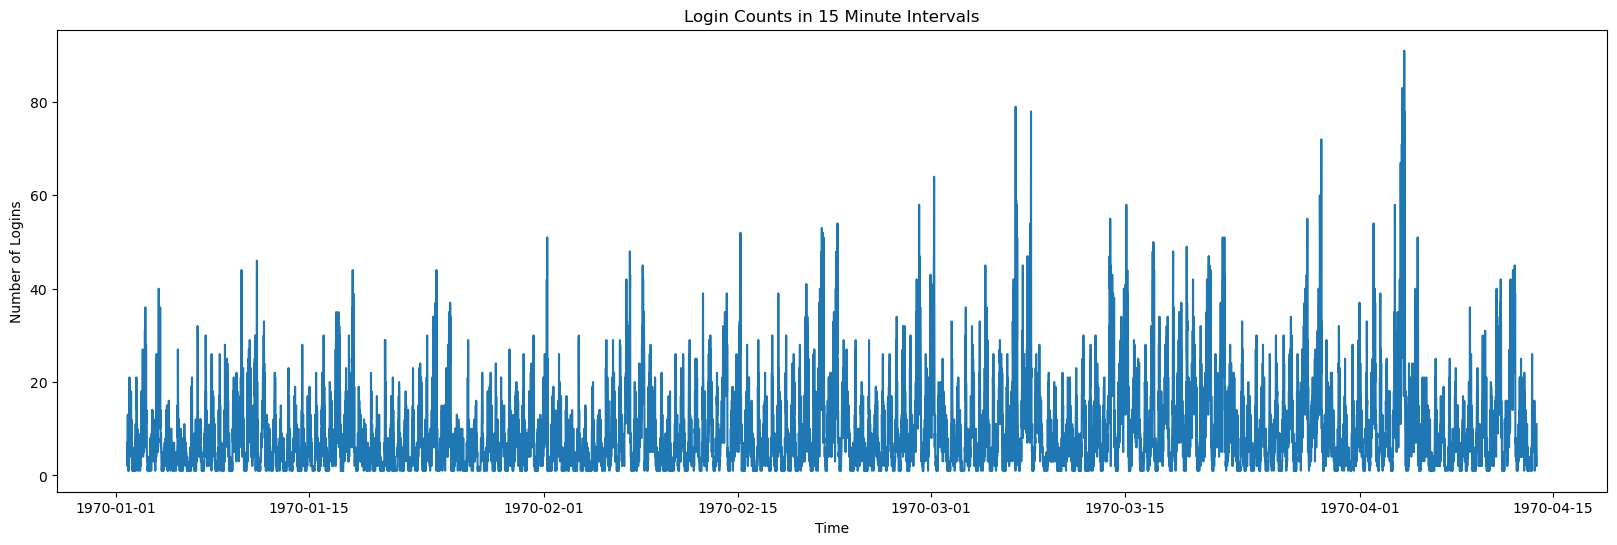

In [16]:
x_axis = bin_end
y_axis = count

plt.figure(figsize=(20,6))
plt.plot(x_axis, y_axis)
plt.title('Login Counts in 15 Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.show()

In [17]:
login_count = pd.DataFrame(list(zip(count, bin_end)), columns = ['Count', 'Bin End'])  

In [18]:
login_count.head()

,Count,Bin End
0,7,1970-01-01 20:28:18
1,2,1970-01-01 20:43:18
2,13,1970-01-01 20:58:18
3,2,1970-01-01 21:13:18
4,4,1970-01-01 21:28:18


In [19]:
day = []
for i in range(y):
    day.append(login_count['Bin End'][i].weekday())

In [20]:
login_count['Day of Week'] = day

In [21]:
login_count['Hour'] = login_count['Bin End'].dt.strftime("%H")

In [22]:
login_count['Minute'] = login_count['Bin End'].dt.strftime("%M")

In [23]:
login_count['Month'] = login_count['Bin End'].dt.strftime("%m")

In [24]:
login_count['Day'] = login_count['Bin End'].dt.strftime("%d")

In [25]:
login_count.head()

,Count,Bin End,Day of Week,Hour,Minute,Month,Day
0,7,1970-01-01 20:28:18,3,20,28,01,01
1,2,1970-01-01 20:43:18,3,20,43,01,01
2,13,1970-01-01 20:58:18,3,20,58,01,01
3,2,1970-01-01 21:13:18,3,21,13,01,01
4,4,1970-01-01 21:28:18,3,21,28,01,01


In [26]:
rfr = RandomForestRegressor(random_state = 1701)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(login_count.drop(columns=['Bin End', 'Count']), 
                                                    login_count.Count, test_size=0.25, random_state=1701)

In [28]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=1701)

In [29]:
def regression_metrics(y_true, y_pred):
    meanAbErr = metrics.mean_absolute_error(y_true, y_pred)
    meanSqErr = metrics.mean_squared_error(y_true, y_pred)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('R squared:', r2)
    print('Mean Absolute Error:', meanAbErr)
    print('Mean Square Error:', meanSqErr)
    print('Root Mean Square Error:', rootMeanSqErr)
    print('Mean Absolute Percentage Error:', mape)

In [30]:
y_pred = rfr.predict(X_test)

In [31]:
regression_metrics(y_test, y_pred)

R squared: 0.5627586557704707
Mean Absolute Error: 3.955929709848794
Mean Square Error: 34.3645258684103
Root Mean Square Error: 5.862126394782894
Mean Absolute Percentage Error: 0.6858446490020944


In [32]:
importances = rfr.feature_importances_

In [33]:
rfr_importances = pd.Series(importances, index = X_test.columns)
rfr_importances = rfr_importances.sort_values(ascending = False)

In [34]:
rfr_importances

Hour           0.458930
Day of Week    0.190004
Day            0.145104
Minute         0.116185
Month          0.089776
dtype: float64

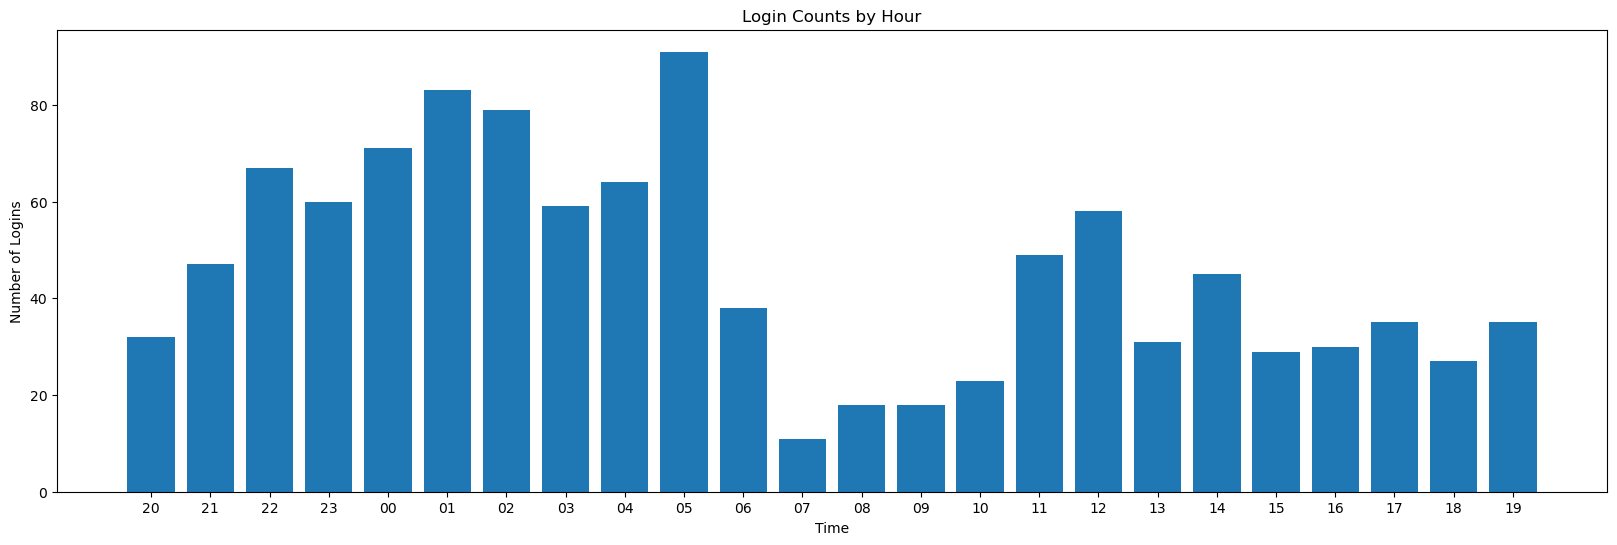

In [35]:
x_axis = login_count['Hour']
y_axis = count

plt.figure(figsize=(20,6))
plt.bar(x_axis, y_axis)
plt.title('Login Counts by Hour')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.show()

In [36]:
login_count['Weekday'] = login_count['Bin End'].dt.strftime("%A")

In [37]:
login_count.sort_values('Day of Week')

,Count,Bin End,Day of Week,Hour,Minute,Month,Day,Weekday
9786,11,1970-04-13 18:58:18,0,18,58,04,13,Monday
2387,2,1970-01-26 17:13:18,0,17,13,01,26,Monday
2386,10,1970-01-26 16:58:18,0,16,58,01,26,Monday
2385,3,1970-01-26 16:43:18,0,16,43,01,26,Monday
2384,6,1970-01-26 16:28:18,0,16,28,01,26,Monday
...,...,...,...,...,...,...,...,...
1614,14,1970-01-18 15:58:18,6,15,58,01,18,Sunday
1613,8,1970-01-18 15:43:18,6,15,43,01,18,Sunday
1612,12,1970-01-18 15:28:18,6,15,28,01,18,Sunday
1621,5,1970-01-18 17:43:18,6,17,43,01,18,Sunday


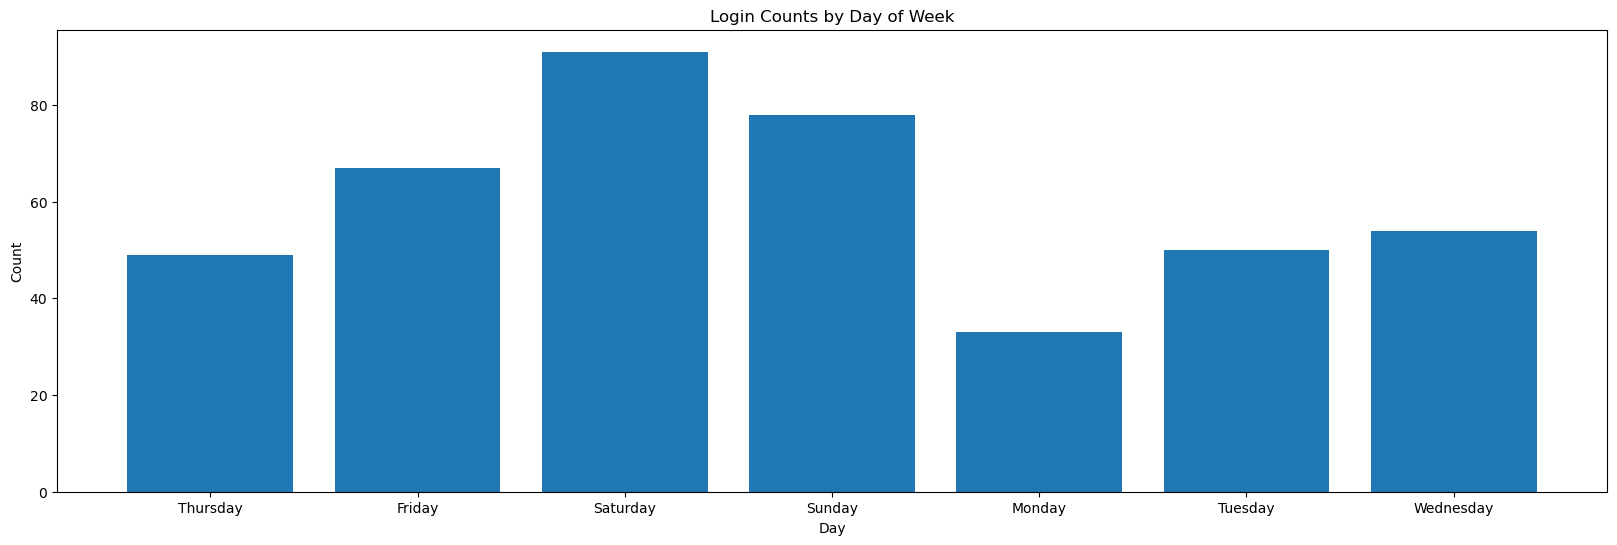

In [39]:
x_axis = login_count['Weekday']
y_axis = count
plt.figure(figsize=(20,6))
plt.bar(x_axis, y_axis)
plt.title('Login Counts by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')

plt.show()

In [ ]:
'''There are several problems with the data. 1) The data is very old. It is hard to imagine that it could be of any business use.
2) There is no time zone associated with the timestamps. It would have to be verified separately that the data come from the same time
zone or are otherwise converted for usefulness 3) The data only covers Jan-April of 1970, a very limited timeframe.

As requested the data was initially binned by 15 minute intervals. I chose the end time, but an early version of this notebook 
used the start time of the interval. There were no significant differences in the graphs from either version. 
After running the Random Forest Regressor and it's modest performance. I decided to look at the features it determined most 
important. The first of these was the hour that the 15 minute interval ended in. The most popular times for login where 
approximately between 10pm and 5am. With a sharp drop off in the 6am - 10 am hours. Also of note the Friday, Saturday, and Sunday
all had the highest number of logins. Saturday being the most popular. Monday being the least popular. '''